<a href="https://colab.research.google.com/github/fagonzalezo/sklearn-kdcrf/blob/master/examples/approximation_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup code

In [1]:
# Install kdrcf if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
  
except:
  IN_COLAB = False

if IN_COLAB:
    
    !git clone https://github.com/fagonzalezo/sklearn-kdcrf.git
    !mv sklearn-kdcrf/kdcrf .
    

In [33]:
%matplotlib inline
import pylab as pl
import numpy as np
import pandas as pd
import gzip
!pip install wget
import wget

In [3]:
# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    
    
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Función para visualizar de la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun):
    print(X.shape)
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict_proba(x)[0][1]
    return pred_fun

In [4]:
## 50th l2 nearest neighborhood and get an approximate sigma

def get_nearest_neighborhood(X):
    random_selection = np.random.choice(a=range(0, X.shape[0]), size=1000, replace=True)
    np.linalg.norm()


In [5]:
##exact kernel
from sklearn.metrics.pairwise import pairwise_kernels

In [6]:
##approximate kernel RFF
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import mean_squared_error
from kdcrf import RBFSamplerORF
from kdcrf import RBFSamplerSORF
import time
import gc


def calculate_mean_square_error(dataset, gamma=2**-1):

    exact_rbf_kernel =  pairwise_kernels(X=dataset, Y=dataset, metric="rbf", gamma=1)

    ratio_d = range(1,10)
    
    n_features = dataset.shape[1]
    
    mse = {}
    classifiers = {'rbf rff': RBFSampler(gamma=gamma, random_state=1), 
                   'rbf orf': RBFSamplerORF(gamma=gamma, random_state=1),
                   #'rbf sorf': RBFSamplerSORF(gamma=gamma, random_state=1),
                   'rbf rff square': RBFSampler(gamma=gamma/2, random_state=1),
                   'rbf orf square': RBFSamplerORF(gamma=gamma/2, random_state=1),
                   #'rbf sorf square': RBFSamplerSORF(gamma=gamma/2, random_state=1)
            }
    
    for clfn in classifiers.keys():
        mse[clfn] = []
    
    for clfn, clf in classifiers.items():
        for i in ratio_d:
            start_time = time.time()
            print("sampler: ", clfn, "n_components:", n_features*(i))
            clf = clf.set_params(n_components=n_features*(i))
            clf.fit(dataset)
            rff = clf.transform(dataset)
            if clfn in ('rbf rff square', 'rbf orf square', 'rbf sorf square'):
                rff_kernel_matrix = np.power(np.dot(rff, rff.T), 2) 
            else:
                rff_kernel_matrix = np.dot(rff, rff.T)
            
            ## error of the approximation
            mse[clfn].append(mean_squared_error(exact_rbf_kernel, rff_kernel_matrix))
            del rff_kernel_matrix, rff
            gc.collect()
            print("--- %s seconds ---" % (time.time() - start_time))
    return mse, classifiers, ratio_d

## Kernel approximation for letters

In [ ]:
letter = wget.download("https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data")

In [ ]:

letters = pd.read_csv("letter-recognition.data", header=None)
print(letters.head())
print(letters.describe())

vector_letters = letters.values[:,1:]


In [ ]:
mse, classifiers, ratio_d = calculate_mean_square_error(vector_letters)

for clfn in classifiers.keys(): 
    pl.plot(np.arange(len(ratio_d)), mse[clfn], label=clfn)
pl.axes().set_xticks(np.arange(len(ratio_d)))
pl.axes().set_xticklabels(ratio_d)
pl.setp(pl.axes().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
pl.legend()


In [ ]:
import h5py
with h5py.File("usps.h5", 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]

In [ ]:
X_tr

In [ ]:
mse, classifiers, ratio_d = calculate_mean_square_error(X_tr)

for clfn in classifiers.keys(): 
    pl.plot(np.arange(len(ratio_d)), mse[clfn], label=clfn)
pl.axes().set_xticks(np.arange(len(ratio_d)))
pl.axes().set_xticklabels(ratio_d)
pl.setp(pl.axes().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
pl.legend()



In [ ]:
# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,
                                          Nystroem)
from sklearn.decomposition import PCA

# The digits dataset
digits = datasets.load_digits(n_class=9)

n_samples = len(digits.data)
data = digits.data / 16.
data -= data.mean(axis=0)

# We learn the digits on the first half of the digits
data_train, targets_train = (data[:n_samples // 2],
                             digits.target[:n_samples // 2])


# Now predict the value of the digit on the second half:
data_test, targets_test = (data[n_samples // 2:],
                           digits.target[n_samples // 2:])

In [ ]:
mse, classifiers, ratio_d = calculate_mean_square_error(data_train)

for clfn in classifiers.keys(): 
    pl.plot(np.arange(len(ratio_d)), mse[clfn], label=clfn)
pl.axes().set_xticks(np.arange(len(ratio_d)))
pl.axes().set_xticklabels(ratio_d)
pl.setp(pl.axes().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
pl.legend()



## Moon Database

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
#y = y[:, np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

In [ ]:
mse, classifiers, ratio_d = calculate_mean_square_error(X_train,2**-2)

for clfn in classifiers.keys(): 
    pl.plot(np.arange(len(ratio_d)), mse[clfn], label=clfn)
pl.axes().set_xticks(np.arange(len(ratio_d)))
pl.axes().set_xticklabels(ratio_d)
pl.setp(pl.axes().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
pl.legend()



## Forest database

In [ ]:
!pip install wget
import wget
forest = wget.download("http://archive.ics.uci.edu/ml//machine-learning-databases/covtype/covtype.data.gz")

In [ ]:


dataset = pd.read_csv('covtype.data.gz', nrows=100, compression='gzip',
                   error_bad_lines=False)

print(dataset)


In [ ]:
mse, classifiers, ratio_d = calculate_mean_square_error(dataset)

for clfn in classifiers.keys(): 
    pl.plot(np.arange(len(ratio_d)), mse[clfn], label=clfn)
pl.axes().set_xticks(np.arange(len(ratio_d)))
pl.axes().set_xticklabels(ratio_d)
pl.setp(pl.axes().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
pl.legend()


## Cifar database


In [7]:
from examples.load_cifar_10 import cifar10

train_images, onehot_train_labels, test_images, onehot_test_labels = cifar10()

In [8]:
train_images = train_images[:10000]

sampler:  rbf rff n_components: 3072
--- 7.6759748458862305 seconds ---
sampler:  rbf rff n_components: 6144
--- 12.120946407318115 seconds ---
sampler:  rbf rff n_components: 9216
--- 16.32336926460266 seconds ---
sampler:  rbf rff n_components: 12288
--- 18.377518892288208 seconds ---
sampler:  rbf rff n_components: 15360
--- 24.171010971069336 seconds ---
sampler:  rbf rff n_components: 18432
--- 35.721121072769165 seconds ---
sampler:  rbf rff n_components: 21504
--- 40.581772565841675 seconds ---
sampler:  rbf rff n_components: 24576
--- 51.34920883178711 seconds ---
sampler:  rbf rff n_components: 27648
--- 49.79790234565735 seconds ---
sampler:  rbf orf n_components: 3072
--- 13.914244651794434 seconds ---
sampler:  rbf orf n_components: 6144
--- 22.310211181640625 seconds ---
sampler:  rbf orf n_components: 9216
--- 31.181228160858154 seconds ---
sampler:  rbf orf n_components: 12288
--- 37.89983868598938 seconds ---
sampler:  rbf orf n_components: 15360
--- 49.59190773963928 s

c:\proyectos\sklearn-kdcrf\venv\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
c:\proyectos\sklearn-kdcrf\venv\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
c:\proyectos\sklearn-kdcrf\venv\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the 

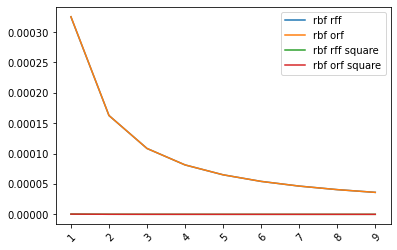

In [9]:
mse, classifiers, ratio_d = calculate_mean_square_error(train_images)

for clfn in classifiers.keys(): 
    pl.plot(np.arange(len(ratio_d)), mse[clfn], label=clfn)
pl.axes().set_xticks(np.arange(len(ratio_d)))
pl.axes().set_xticklabels(ratio_d)
pl.setp(pl.axes().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
pl.legend()



## MNIST

In [10]:
from requests import get

def download_file(url, file_name):
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)
        

In [11]:
download_file('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')

In [27]:
def read_mnist(images_path: str, labels_path: str):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784)
        
    return features, labels

features, labels = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')

In [28]:
features.shape

(60000, 784)

sampler:  rbf rff n_components: 784
--- 4.879883766174316 seconds ---
sampler:  rbf rff n_components: 1568
--- 6.317342758178711 seconds ---
sampler:  rbf rff n_components: 2352
--- 9.237790822982788 seconds ---
sampler:  rbf rff n_components: 3136
--- 8.03811502456665 seconds ---
sampler:  rbf rff n_components: 3920
--- 6.977380990982056 seconds ---
sampler:  rbf rff n_components: 4704
--- 8.326149940490723 seconds ---
sampler:  rbf rff n_components: 5488
--- 11.207072257995605 seconds ---
sampler:  rbf rff n_components: 6272
--- 12.734408378601074 seconds ---
sampler:  rbf rff n_components: 7056
--- 12.378313541412354 seconds ---
sampler:  rbf orf n_components: 784
--- 5.116123199462891 seconds ---
sampler:  rbf orf n_components: 1568
--- 7.508210182189941 seconds ---
sampler:  rbf orf n_components: 2352
--- 8.416555643081665 seconds ---
sampler:  rbf orf n_components: 3136
--- 9.612996816635132 seconds ---
sampler:  rbf orf n_components: 3920
--- 11.76791524887085 seconds ---
sample

c:\proyectos\sklearn-kdcrf\venv\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
c:\proyectos\sklearn-kdcrf\venv\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
c:\proyectos\sklearn-kdcrf\venv\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the 

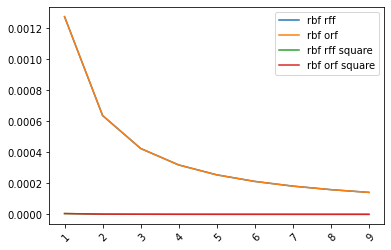

In [30]:
mse, classifiers, ratio_d = calculate_mean_square_error(features[0:10000,:])

for clfn in classifiers.keys(): 
    pl.plot(np.arange(len(ratio_d)), mse[clfn], label=clfn)
pl.axes().set_xticks(np.arange(len(ratio_d)))
pl.axes().set_xticklabels(ratio_d)
pl.setp(pl.axes().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
pl.legend()



##Gisette

In [34]:

wget.download("https://archive.ics.uci.edu/ml/machine-learning-databases/gisette/GISETTE/gisette_train.data")

'gisette_train.data'

In [46]:

gisette = pd.read_csv("gisette_train.data", header=None, sep=" ")
print(gisette.head())
print(gisette.describe())

   0     1     2     3     4     5     6     7     8     9     ...  4991  \
0   550     0   495     0     0     0     0   976     0     0  ...     0   
1     0     0     0     0     0     0     0   976     0     0  ...   475   
2     0     0     0     0     0     0     0     0     0     0  ...     0   
3     0     0   742     0     0     0     0   684     0   956  ...     0   
4     0     0     0     0     0     0     0   608     0   979  ...     0   

   4992  4993  4994  4995  4996  4997  4998  4999  5000  
0     0   991   991     0     0     0     0   983   NaN  
1     0   991     0     0   991     0     0     0   NaN  
2     0     0     0     0     0     0     0     0   NaN  
3     0     0     0     0   674     0     0   838   NaN  
4     0   828     0     0     0     0     0     0   NaN  

[5 rows x 5001 columns]
              0            1            2            3            4     \
count  6000.000000  6000.000000  6000.000000  6000.000000  6000.000000   
mean    111.022833    

In [50]:
gisette = gisette.loc[:, 0:4999]

In [52]:
gisette.shape

(6000, 5000)

sampler:  rbf rff n_components: 5000
--- 8.887234449386597 seconds ---
sampler:  rbf rff n_components: 10000
--- 16.358510732650757 seconds ---
sampler:  rbf rff n_components: 15000
--- 24.34269118309021 seconds ---
sampler:  rbf rff n_components: 20000
--- 28.20645499229431 seconds ---
sampler:  rbf rff n_components: 25000
--- 36.20362949371338 seconds ---
sampler:  rbf rff n_components: 30000
--- 41.89373254776001 seconds ---
sampler:  rbf rff n_components: 35000
--- 58.76637506484985 seconds ---
sampler:  rbf rff n_components: 40000
--- 65.16372656822205 seconds ---
sampler:  rbf rff n_components: 45000
--- 64.3708484172821 seconds ---
sampler:  rbf orf n_components: 5000
--- 44.01228642463684 seconds ---
sampler:  rbf orf n_components: 10000
--- 90.52014970779419 seconds ---
sampler:  rbf orf n_components: 15000
--- 99.23911046981812 seconds ---
sampler:  rbf orf n_components: 20000
--- 102.93143367767334 seconds ---
sampler:  rbf orf n_components: 25000
--- 116.65705275535583 seco

c:\proyectos\sklearn-kdcrf\venv\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
c:\proyectos\sklearn-kdcrf\venv\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
c:\proyectos\sklearn-kdcrf\venv\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the 

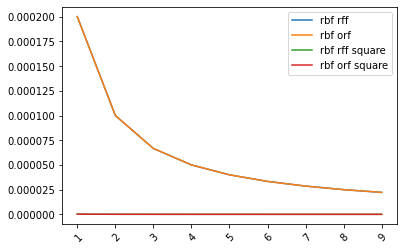

In [53]:
mse, classifiers, ratio_d = calculate_mean_square_error(gisette)

for clfn in classifiers.keys(): 
    pl.plot(np.arange(len(ratio_d)), mse[clfn], label=clfn)
pl.axes().set_xticks(np.arange(len(ratio_d)))
pl.axes().set_xticklabels(ratio_d)
pl.setp(pl.axes().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
pl.legend()